In [10]:
# If having trouble with viewing, see https://nbviewer.org/github/s-disalvo/Python-portfolio/blob/main/Data%20Analysis/hockey_ver1.ipynb

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt 

/var/folders/sk/hy9vpyt94dx3wh_1ctycmgsr0000gn/T/ipykernel_16146/230980069.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
dataset_file = "/Users/Sydney/Desktop/Job Stuff/Portfolio/My Copy of Hockey Arena Rankings - Sheet1.csv"

df=pd.read_csv(dataset_file)

df.head()

,Rank,Arena Name,Location,Team/Tournament,League,Arena Type,Character,Ammenities,Atmosphere,Year First Visited,Year Last Visited,Coordinates
0,1,Yost Ice Arena,"Ann Arbor, MI, United States",University of Michigan,NCAA DI,Indoor,5/5,4/5,5/5,2011,2023,"42.2676084,-83.7436157"
1,2,Matthews Arena,"Boston, MA, United States",Northeastern University,NCAA DI,Indoor,5/5,3/5,4/5,2012,2016,"42.3410806,-71.0872167"
2,3,Cornèr Arena,"Lugano, SUI",HC Lugano,NL,Indoor,4/5,4/5,5/5,2023,2023,"46.0261635,8.9611814"
3,4,Madison Square Garden,"New York, NY",Red Hot Hockey,NCAA DI,Indoor,4/5,5/5,5/5,2015,2015,"40.7505085,-73.9960136"
4,5,Hobey Baker Rink,"Princeton, NJ",Princeton University,NCAA DI,Indoor,5/5,2/5,4/5,2021,2021,"40.3429238,-74.6603993"


In [3]:
#Remove outdoor rankings
indexArenaType = df[ (df['Arena Type'] == 'Outdoor')].index
df.drop(indexArenaType, inplace=True)

#Remove Rank
df = df.drop('Rank', axis=1)

#Remove duplicates: Delete one of the University of Western Ontario and Roberty Morris University
df = df.replace({'University of Western Ontario\nUniversity of Western Ontario':'University of Western Ontario',
                 'Robert Morris University\nRoberty Morris University':'Robert Morris University'})

#Add new ranking
new_row_nashville_predators = pd.DataFrame({'Arena Name':'Bridgestone Arena','Location':'Nashville, TN',
                                            'Team/Tournament':'Nashville Predators','League':'NHL','Arena Type':'Indoor',
                                            'Character':'4/5','Ammenities':'5/5','Atmosphere':'5/5',
                                            'Year First Visited':2024,'Year Last Visited':2024,'Coordinates':'36.1591779,-86.7810708'},
                                                            index =[0])
#Concat into the existing df
df = pd.concat([new_row_nashville_predators, df]).reset_index(drop = True)

#Split coordinates 
df[['Latitude', 'Longitude']] = df['Coordinates'].str.split(',', expand=True)

In [4]:
#Change x/5 to just x in Character, Ammenities, and Atmosphere, set as int
df = df.replace({'1/5':'1','2/5':'2','3/5':'3','4/5':'4','5/5':'5'})

df[['Character','Ammenities','Atmosphere']] = df[['Character','Ammenities','Atmosphere']].astype(int)
#remove/replace the one ~ symbol in Year First Visited, set to int
df = df.replace({'~1993':'1993'})
df['Year First Visited'] = df['Year First Visited'].astype(int)

#set lat & long to float
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype(float)

In [5]:
# Create new row, sum of three category rankings
df['Total'] = df.apply(lambda row: row['Character'] + row['Ammenities'] +row['Atmosphere'], axis=1)

In [6]:
rink_map = folium.Map(location=[40.4406, -79.9959], zoom_start=6)
#Pittsburg (location central for the US only rinks): 40.4406, -79.9959
#Middle of the ocean (location for all rinks): 41.329348, -51.190864

# instantiate a feature group for the rinks in the dataframe
ranked_rinks = folium.map.FeatureGroup()

# loop through the rinks and add each to the incidents feature group
for lat, lng in zip(df.Latitude, df.Longitude):
    ranked_rinks.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

for (index, row) in df.iterrows():
    if row.loc['Arena Name']:
        iframe = folium.IFrame('<h3> <b>'+ str(row.loc['Arena Name']) + '</h3> </b>' 
                               + '<h5>' + str(row.loc['Location']) + '</h5>'
                               + '<b>' + row.loc['Team/Tournament'] + '</b>' + '<br>' 
                               + row.loc['League'] + '<br>' 
                               + 'Character: ' + str(row.loc['Character']) + '<br>' 
                               + 'Ammenities: ' + str(row.loc['Ammenities']) + '<br>'
                               + 'Atmosphere: ' + str(row.loc['Atmosphere']))
        labels = folium.Popup(iframe, min_width=350, max_width=350)
        folium.Marker(
            location=[row.loc['Latitude'], row.loc['Longitude']],popup=labels, tooltip= row.loc['Arena Name']).add_to(rink_map)
 
rink_map

In [7]:
# if NCAAW, then add column: men/women. Then replace NCAAW with just NCAA + division 

# Define the function to categorize genders
df['Gender'] = np.select([df['League'] == 'NCAAW DI' , df['Arena Name'] == 'Thompson Recreation and Athletic Centre'], ['Women', 'Men & Women'], default='Men')

df = df.replace({'NCAAW DI':'NCAA DI'})

In [8]:
df[['Character','Ammenities','Atmosphere']] = df[['Character','Ammenities','Atmosphere']].astype(int)
league_group = df.groupby('League',as_index=False)[['Character','Ammenities','Atmosphere','Total']].mean().apply(lambda x: round(x, 2))

league_group

,League,Character,Ammenities,Atmosphere,Total
0,ACHA DI,1.33,2.00,2.67,6.00
1,ACHA DII,2.25,1.75,1.25,5.25
2,ACHA DIII,1.00,2.00,2.00,5.00
3,AHL,2.78,4.11,2.78,9.67
4,ECHL,3.60,4.00,3.80,11.40
5,FHL,2.00,2.00,1.00,5.00
6,FPHL,4.00,3.00,5.00,12.00
7,GOJHL,4.00,2.67,2.67,9.33
8,ICEHL,4.00,2.00,5.00,11.00
9,NAHL,4.00,3.00,3.00,10.00


In [9]:
df.to_csv('hockey_ver1.csv', index=False)

([<matplotlib.patches.Wedge at 0x157532d10>,
 [Text(-1.0934010664770113, 0.12030838635329699, 'Men'),
  Text(1.0882776880999934, -0.16016139854451153, 'Women'),
  Text(1.0992661289811692, -0.04017434099964386, 'Men & Women')],
 [Text(-0.5964005817147334, 0.06562275619270745, '96.5%\n(83)'),
  Text(0.5936060116909053, -0.08736076284246082, '2.3%\n(2)'),
  Text(0.5995997067170014, -0.021913276908896644, '1.2%\n(1)')])

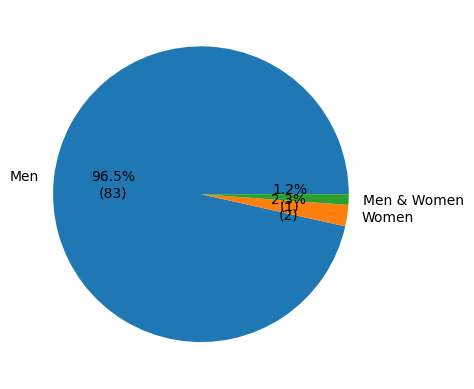

In [9]:
# Pie chart for distribution of league
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

pie_gender = df['Gender'].value_counts()
plt.pie(pie_gender,labels = pie_gender.index, autopct=autopct_format(pie_gender))

([<matplotlib.patches.Wedge at 0x157746790>,
 [Text(0.5383595970851739, 0.959254368885693, 'NCAA DI'),
  Text(-0.8455119008679304, 0.703640267104363, 'AHL'),
  Text(-1.0970655167503502, 0.08029478163173034, 'NCAA DIII'),
  Text(-0.9782763322854221, -0.5029666168745025, 'NHL'),
  Text(-0.6722910222381218, -0.8706461861273047, 'ECHL'),
  Text(-0.35516836477645103, -1.041083777926648, 'OHL'),
  Text(-0.04017414159074347, -1.0992661362688505, 'ACHA DII'),
  Text(0.2391732802228492, -1.07368344591292, 'GOJHL'),
  Text(0.4669024603885133, -0.9959930182903658, 'ACHA DI'),
  Text(0.640044894039352, -0.8946186526191787, 'USHL'),
  Text(0.763481691255978, -0.791893747365713, 'USports'),
  Text(0.8706462018634115, -0.6722910018591771, 'PJHL'),
  Text(0.9389524527621512, -0.5730342847089869, 'ICEHL'),
  Text(0.978276411751697, -0.5029664623115784, 'FPHL'),
  Text(1.0123808428497303, -0.43021509623776555, 'NL'),
  Text(1.0410837841616345, -0.3551683465002076, 'NAHL'),
  Text(1.0642320930776668, -0.

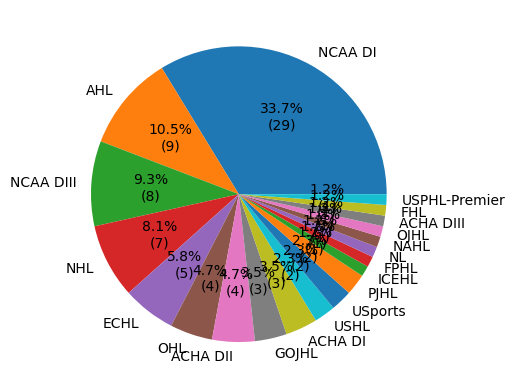

In [10]:
pie_league = df['League'].value_counts()
plt.pie(pie_league,labels=pie_league.index, autopct=autopct_format(pie_league))

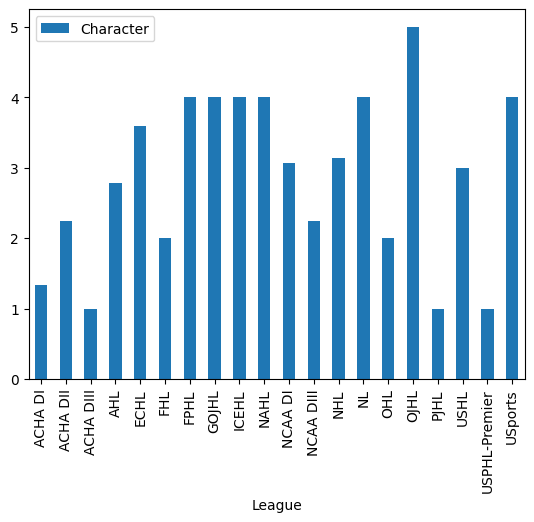

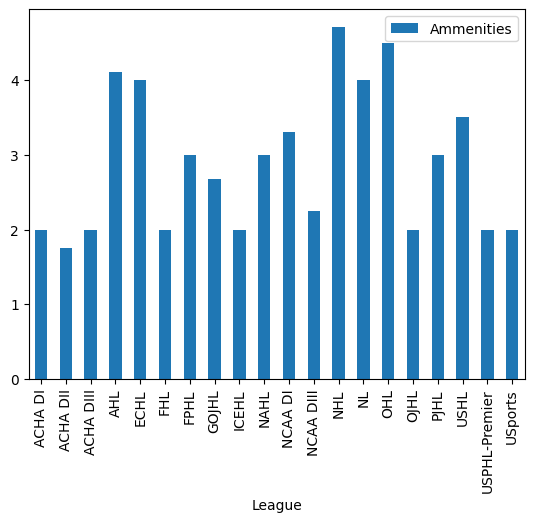

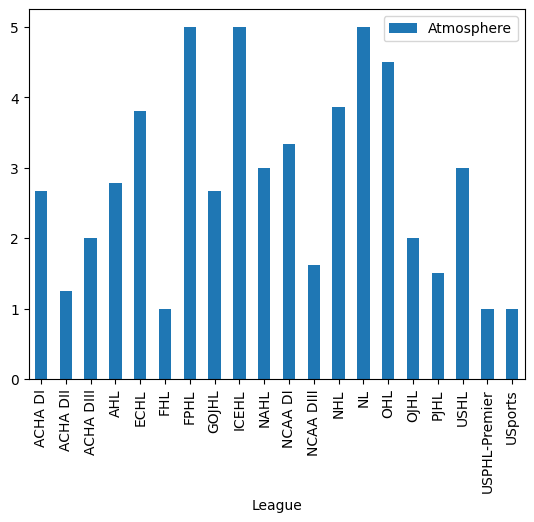

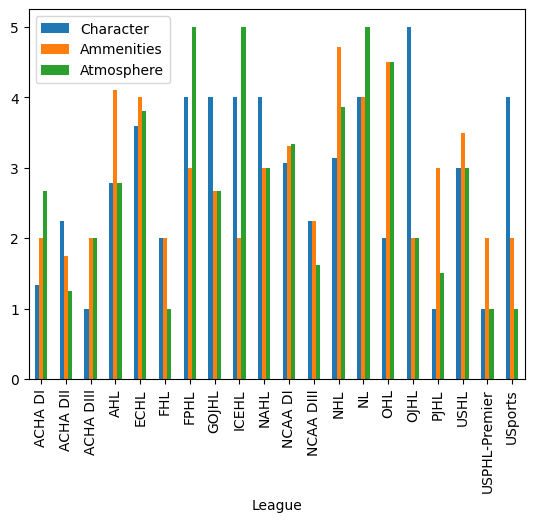

In [403]:
# Men's vs women's average or avg by league 

bar_character = league_group.plot.bar(x='League', y='Character')

bar_ammenities = league_group.plot.bar(x='League', y='Ammenities')

bar_atmosphere = league_group.plot.bar(x='League', y='Atmosphere')

bar_all_categories = league_group.plot.bar(x='League', y=['Character','Ammenities','Atmosphere'])